<div align=center>
<br/>
<br/>
<font color=#FF7500>
Sharif University of Technology - Departmenet of Computer Engineering
</font>
<p></p>
<font color=blue>
Artifical Intelligence - Dr. Mahdieh Soleimani
</font>
<br/>
<br/>
Fall 2022





In this assignment you will solve the traveling salesman problem using hill climbing, simulated annealing and genetic algorithms.

In [1]:
# do not import other packages for this assignment
import matplotlib.pyplot as plt
import numpy as np

The traveling salesperson problem (TSP) is a touring problem in which each city must be visited exactly once. The aim is to find the shortest tour. The problem is known to be NP-hard, but an enormous amount of effort has been expended to improve the capabilities of TSP algorithms. In addition to planning trips for traveling salespersons, these algorithms have been used for tasks such as planning movements of automatic circuit-board drills and of stocking machines on shop floors.

In this notebook we will use matplotlib library to visualize the problem. we represent each city as a point in a 800*800 rectnagle. the positions of the cities are randomly chosen. run the next codeblock to randomly choose the cities.

In [2]:
WIDTH = 800
HEIGHT = 800
CITY_NUM = 30


class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y


cities = [City(np.random.randint(10,WIDTH-10),np.random.randint(10,HEIGHT-10)) for i in range(CITY_NUM)] 

The next function helps you visualize the problem.

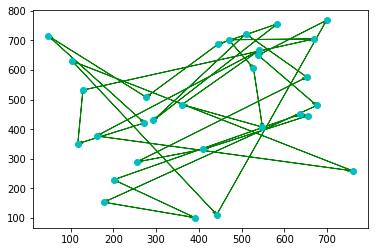

In [3]:
def plotTSP(cities):
    '''
    Inputs:
    - cities : list of cities. ordered by path
    '''
    x = []
    y = []
    for city in cities:
        x.append(city.x)
        y.append(city.y)
    plt.plot(x,y,'co')
    
    a_scale = float(max(x))/float(100)
    plt.arrow(x[-1], y[-1], (x[0] - x[-1]), (y[0] - y[-1]), head_width = a_scale, 
            color ='g', length_includes_head=True)
    for i in range(0,len(x)-1):
        plt.arrow(x[i], y[i], (x[i+1] - x[i]), (y[i+1] - y[i]), head_width = a_scale,
                color = 'g', length_includes_head = True)

plotTSP(cities)

complete the following helper functions. a test cases has been given to you to make sure your implement these functions correctly.

In [4]:
# 5 points

def get_distance_between_two_city(c1 : City, c2 : City):
    '''
    Inputs:
    - c1,c2 : the two cities of type City
    Output: Euclidean distance between them.
    '''
    return np.sqrt((c1.x - c2.x)**2 + (c1.y - c2.y)**2)

def get_distance_tsp(cities):
    '''
    Inputs:
    - cities : list of cities of form [c1, c2, ..., cn]. ordered by path
    Output: tsp distance.
    '''
    sum_distance = 0
    for i in range(len(cities) - 1):
        sum_distance += get_distance_between_two_city(cities[i+1], cities[i])
    sum_distance += get_distance_between_two_city(cities[0], cities[-1])
    return sum_distance


# testcase
c1 = City(10, 10)
c2 = City(10, 20)
c3 = City(20, 10)
c4 = City(40, 40)
dist_tsp = get_distance_tsp([c1,c2,c3,c4])  # should be around 102.62
print(dist_tsp)

102.6240552495637


# Algorithm 1 : Hill Climbing (12 points)

implement a hill climbing algorithm for the problem. you dont have to add sideways move to the hill climbing algorithm. meaning that if a neighbor with a smaller path length does not exist you can terminate and return the existing path as the solution. we define a neighbouring solution as changing the place of two cities. for example if our solution is [c1, c2, c3, c4, c5] then one of the possible next solution would be [c4, c2, c3, c1, c5].   
at each timestep generate all the possible next solution and pick the best one. if one does not exist return the current solution.  

* make sure to use the .copy function when you want to have another copy of a list.
* print the the distance at each iteration of hill climbing


initial path length=10032.147817366924, path length of hill climbing=4639.053795236846


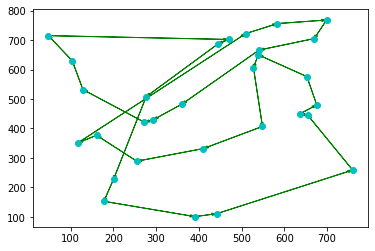

In [7]:
def tsp_hill_climbing(cities):
    '''
    Inputs:
    - cities   : list of cities of form [c1, c2, ..., cn]. ordered by path.
    Output:
    - solution : list of cities of form [c1, c2, ..., cn]. ordered by path.
    '''
    current_state = cities
    current_best = cities
    while True:
        # displacement of first and last cities
        neighbor = current_state.copy()
        neighbor[0], neighbor[-1] = neighbor[-1], neighbor[0]
        if get_distance_tsp(neighbor) < get_distance_tsp(current_best):
            current_best = neighbor
        # displacement of rest of cities
        for i in range(len(cities)-1):
            for j in range(i+1, len(cities)-1, 1):
                neighbor = current_state.copy()
                neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
                if get_distance_tsp(neighbor) < get_distance_tsp(current_state):
                    current_best = neighbor
        # after checking all neighbors, if no better neighbor, return current best
        if current_best == current_state:
            return current_best
        # if there is better neighbor, update current state
        current_state = current_best 


solution = tsp_hill_climbing(cities)
print(f'\ninitial path length={get_distance_tsp(cities)}, path length of hill climbing={get_distance_tsp(solution)}')
plotTSP(solution)

# Algorithm 2: Simulated Annealing (13 points)

In this part we will use simulated annealing to solve the tsp problem. In order to generate a random neighbor of a state. choose two cities at random. then flip a fair coin and do one of the following based on the outcome.  
1 - change the position of the two cities (like algorithm 1)  
2 - reverse the cities between these two cities. example : our initial state is [1,2,3,4,5,6] and the two chosen cities are 2 and 5. the resulting neighbor will be [1,5,4,3,2,6] 
we will use exponential decay as a way to schedule the temparture. meaning that in each iteration the temperature is changed to alpha*temperature.    
at each iteration if the neighbour path length is less than the current state we accept that state as our current state. otherwise we will accept it based on the following probability:  
$$p= {e}^{-\frac{\Delta length}{T}}$$
stop the algorithm when temperature is less than a small number. here we will use the variable stopping_temperature for this.


initial path length=10032.147817366924, path length of simulated annealing=3831.142937954231


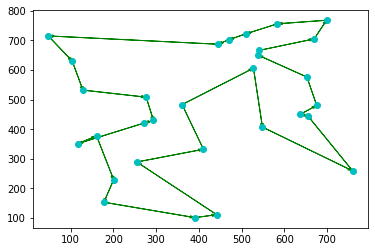

In [8]:
def get_neighbour_state(cities):
    '''
    Inputs:
    - cities    : list of cities of form [c1, c2, ..., cn]. ordered by path.
    Output:
    - neighbour : list of cities of form [c1, c2, ..., cn]. ordered by path.
                  find this neighbour based on the information above.
    '''
    # choose to random cities to swap
    i = np.random.randint(0, len(cities))
    j = np.random.randint(0, len(cities))
    # flip a coin to decide whether to swap or reverse cities
    if np.random.random() < 0.5: # swap
        cities[i], cities[j] = cities[j], cities[i]
    else: # reverse 
        cities[i:j] = cities[i:j][::-1]
    
    return cities
        
         
def simulated_annealing(cities, T=300, alpha=0.99, stopping_temperature=1e-8):
    '''
    Inputs:
    - cities               : list of cities of form [c1, c2, ..., cn]. ordered by path.
    - T                    : the temperature value of simulated annealing.
    - alpha                : exponential decay factor for T.
    - stopping_temparature : stop the alogorithm if T drops below this.
    Output:
    - solution             : list of cities of form [c1, c2, ..., cn]. ordered by path.
    '''
    current_state = cities
    while T > stopping_temperature:
        neighbour = get_neighbour_state(current_state.copy())
        if get_distance_tsp(neighbour) < get_distance_tsp(current_state):
            current_state = neighbour
        else:
            # probabilistic assignment in bad cases
            if np.random.random() < np.exp(-(get_distance_tsp(neighbour) - get_distance_tsp(current_state)) / T):
                current_state = neighbour
        T *= alpha
    return current_state

solution = simulated_annealing(cities)
print(f'\ninitial path length={get_distance_tsp(cities)}, path length of simulated annealing={get_distance_tsp(solution)}')
plotTSP(solution)

# Algorithm 3: genetic algorithm (optional 10 points)

This part is optional and you can earn up to 10 extra point from it. In the theoretical part of this assignment, you created a genetic algorithm for the TSP problem. implement you algotihm here and plot the solution at the end.


initial path length=10032.147817366924, path length of genetic algorithm=3927.6500540792413


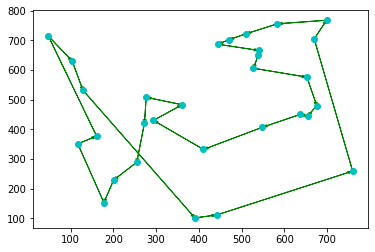

In [50]:
def initializtion(cities, k):
    population = []
    for i in range(k):
        population.append(np.array(cities.copy()))
        np.random.shuffle(population[i])
    return np.array(population)

def get_fitness(stat, max_dist):
    # with respect to: "the shorter the path, the better the fitness"
    return np.exp(-get_distance_tsp(stat) / max_dist)

def get_fitness_population(population):
    fitness_population = []
    max_dist = get_distance_tsp(population[np.argmax([get_distance_tsp(i) for i in population])])
    for i in range(len(population)):
        fitness_population.append(get_fitness(population[i], max_dist))
    return fitness_population

def get_probabilities(population):
    probabilities = []
    fitness_population = get_fitness_population(population)
    sum_fit_pop = sum(fitness_population)
    for i in range(len(fitness_population)):
        probabilities.append(fitness_population[i] / sum_fit_pop)
    return probabilities

def selection(population, k, probabilities):
    selected_indices = np.random.choice(range(len(population)), size=k, replace=True, p=probabilities)
    selected = population[selected_indices]
    return selected

def crossover(parent1, parent2):
    child = []
    # Greedy crossover
    child.append(parent1[0])
    for i in range(1, len(parent1)):
        candidate1 = parent1[i]
        candidate2 = parent2[i]
        if candidate1 in child and candidate2 not in child:
            child.append(candidate2)
        elif candidate1 not in child and candidate2 in child:
            child.append(candidate1)
        elif candidate1 not in child and candidate2 not in child:
            # choose the nearest city
            if get_distance_between_two_city(child[i-1], candidate1) < get_distance_between_two_city(child[i-1], candidate2):
                child.append(candidate1)
            else:
                child.append(candidate2)
        else:
            # randomly choose a non selected city
            bucket = [city for city in parent1 if city not in child]
            child.append(np.random.choice(bucket))
    return child

def mutation(child, mutation_rate=0.3):
    for count in range(int(mutation_rate * len(child))):
        # choose to random cities to swap
        i = np.random.randint(0, len(child))
        j = np.random.randint(0, len(child))
        # greedy-swap mutation
        copy_child = [city for city in child]
        copy_child[i], copy_child[j] = copy_child[j], copy_child[i]
        if get_distance_tsp(copy_child) < get_distance_tsp(child):
            child = copy_child
    return child

def genetic_algorithm(cities, k=300, generations=1000):
    population = initializtion(cities, k)
    for i in range(generations):
        probabilities = get_probabilities(population)
        selected = selection(population, k, probabilities)
        for j in range(0, k, 2):
            child1, child2 = crossover(selected[j], selected[j+1]), crossover(selected[j+1], selected[j])
            child1 = mutation(child1)
            child2 = mutation(child2)
            population[j] = child1
            population[j+1] = child2
    fitness_population = get_fitness_population(population)
    solution = population[np.argmax(fitness_population)]
    return solution

solution = genetic_algorithm(cities)
for city in cities:
    if city not in solution:
        print(city)

print(f'\ninitial path length={get_distance_tsp(cities)}, path length of genetic algorithm={get_distance_tsp(solution)}')
plotTSP(solution)
###########################################################
##############  might take some time to run   #############
###########################################################